<a href="https://colab.research.google.com/github/FlynnTownie/Anomaly-Annihilators-Capstone/blob/main/IsolationForestCapstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [206]:

import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


# 1

def load_conn_fix_tail(path):
    raw = pd.read_csv(path, sep="\t", comment="#", header=None, engine="python", dtype=str, keep_default_na=False)
    raw = raw.dropna(axis=1, how="all")

    core_cols = ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p',
                 'proto','service','duration','orig_bytes','resp_bytes',
                 'conn_state','local_orig','local_resp','missed_bytes','history',
                 'orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes']

    if raw.shape[1] < 21:
        for _ in range(21 - raw.shape[1]):
            raw[raw.shape[1]] = ""
    last_col = raw.iloc[:, 20:].astype(str).apply(lambda r: "\t".join(r.tolist()), axis=1)
    first_part = raw.iloc[:, :20].copy()
    first_part.columns = core_cols

    tail = last_col.str.replace("\t", " ", regex=False).str.replace(r"\s+", " ", regex=True).str.strip()

    tail = tail.str.replace(r"^- ?", "", regex=True)

    def split_tail(s):
        if not s:
            return "-", "", ""
        parts = s.split(" ")
        if len(parts) == 1:
            return "-", parts[0], ""
        cand = parts[1].lower()
        looks_label = any(k in cand for k in ["benign","malicious","attack","c&c","normal","background","clean"])
        if looks_label:
            tp = parts[0]
            lab = parts[1]
            dlab = " ".join(parts[2:]) if len(parts) > 2 else ""
            return tp, lab, dlab
        tp = "-"
        lab = parts[0]
        dlab = " ".join(parts[1:]) if len(parts) > 1 else ""
        return tp, lab, dlab

    tp_lab = tail.apply(split_tail)
    tp_lab_df = pd.DataFrame(tp_lab.tolist(), columns=["tunnel_parents","label","detailed-label"])

    df = pd.concat([first_part.reset_index(drop=True), tp_lab_df.reset_index(drop=True)], axis=1)
    return df

df = load_conn_fix_tail("/content/conn.log.labeled")
print("Columns:", df.columns.tolist()[:25])
print(df[["tunnel_parents","label","detailed-label"]].head(8))



Columns: ['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'label', 'detailed-label']
  tunnel_parents             label detailed-label
0      Malicious  C&C-FileDownload               
1      Malicious               C&C               
2      Malicious               C&C               
3      Malicious               C&C               
4      Malicious  C&C-FileDownload               
5      Malicious  C&C-FileDownload               
6      Malicious               C&C               
7      Malicious               C&C               


In [207]:
# label selection + mapping
lab  = df.get("label", pd.Series([""]*len(df))).fillna("").str.strip()
dlab = df.get("detailed-label", pd.Series([""]*len(df))).fillna("").str.strip()

def informative(series: pd.Series) -> pd.Series:
    return ~series.str.lower().isin(["", "-", "(empty)"])

src = np.where(informative(lab), lab,
               np.where(informative(dlab), dlab, ""))

def map_label_str(x: str):
    s = str(x).strip().lower()
    if s in {"", "-", "(empty)"}: return np.nan
    if any(k in s for k in ["benign","normal","background","clean"]): return 0
    if any(k in s for k in ["malicious","attack","c&c","botnet"]):  return 1
    if s.isdigit(): return 1 if int(s) != 0 else 0
    return np.nan

y = pd.Series(src).map(map_label_str)
df = df.assign(label_bin=y).dropna(subset=["label_bin"])
y  = df["label_bin"].astype(int)

print("Class distribution after mapping:", y.value_counts().to_dict())


Class distribution after mapping: {0: 211, 1: 26}


In [208]:

# 3 Features & preprocessing

X = df.drop(columns=["label_bin","label","detailed-label"])


for c in ["ts","uid","tunnel_parents"]:
    if c in X.columns:
        X = X.drop(columns=[c])


for c in X.columns:
    if X[c].dtype == object:
        try:
            X[c] = pd.to_numeric(X[c])
        except Exception:
            pass


cat_cols = [c for c in X.columns if X[c].dtype == object]
num_cols = [c for c in X.columns if c not in cat_cols]

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train_t = pre.fit_transform(X_train)
X_test_t  = pre.transform(X_test)



In [209]:
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report

rng = 42  # lock randomness everywhere

# Split train into train/val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=rng)
(train_idx, val_idx), = sss.split(X_train_t, y_train)

X_tr_sub, X_val = X_train_t[train_idx], X_train_t[val_idx]
y_tr_sub, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]


# Train IF on NORMALS only if available, else on all
norm_mask = (y_tr_sub.values == 0)
if norm_mask.any():
    X_fit = X_tr_sub[norm_mask]
    contam_guess = max(0.01, min(0.49, (y_tr_sub == 1).mean()))
else:
    X_fit = X_tr_sub
    contam_guess = max(0.10, min(0.49, (y_tr_sub == 1).mean() or 0.30))

iso = IsolationForest(
    n_estimators=300,
    contamination=contam_guess,  # starting point; real cutoff will come from threshold search
    random_state=rng,
    n_jobs=-1
).fit(X_fit)

# Tune the decision threshold on validation to maximise F1
val_scores = iso.decision_function(X_val)  # higher = more normal

percentiles = np.linspace(1, 40, 80)
best = (-1, None)  # (F1, threshold)
for p in percentiles:
    thr = np.percentile(val_scores, p)
    y_val_pred = (val_scores < thr).astype(int)  # 1 = anomaly
    f1 = f1_score(y_val, y_val_pred, zero_division=0)
    if f1 > best[0]:
        best = (f1, thr)

best_thr = best[1]
print(f"[IF] Tuned threshold on val: F1={best[0]:.3f}, thr={best_thr:.5f}, contam_guess={contam_guess:.3f}")


# final eval
test_scores = iso.decision_function(X_test_t)
y_pred_if = (test_scores < best_thr).astype(int)

acc  = accuracy_score(y_test, y_pred_if)
prec = precision_score(y_test, y_pred_if, zero_division=0)
rec  = recall_score(y_test, y_pred_if, zero_division=0)
f1   = f1_score(y_test, y_pred_if, zero_division=0)
cm   = confusion_matrix(y_test, y_pred_if)

print(f"\n[IsolationForest] Test metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("Confusion [[TN FP]\n           [FN TP]]:\n", cm)
print("\nReport:\n", classification_report(y_test, y_pred_if, digits=4))


[IF] Tuned threshold on val: F1=1.000, thr=-0.00972, contam_guess=0.106

[IsolationForest] Test metrics
Accuracy : 0.9667
Precision: 0.8571
Recall   : 0.8571
F1-score : 0.8571
Confusion [[TN FP]
           [FN TP]]:
 [[52  1]
 [ 1  6]]

Report:
               precision    recall  f1-score   support

           0     0.9811    0.9811    0.9811        53
           1     0.8571    0.8571    0.8571         7

    accuracy                         0.9667        60
   macro avg     0.9191    0.9191    0.9191        60
weighted avg     0.9667    0.9667    0.9667        60



In [210]:
from sklearn.ensemble import IsolationForest
import numpy as np

n_norm_train = int((y_train == 0).sum())
n_anom_train = int((y_train == 1).sum())
print(f"[Train] normals: {n_norm_train}, anomalies: {n_anom_train}")

if n_norm_train > 0:
    X_fit = X_train_t[y_train.values == 0]
    est_contam = max(0.01, min(0.49, (y_train == 1).mean()))
    print(f"Training on NORMAL-only, contamination={est_contam:.3f}")
else:
    X_fit = X_train_t
    est_contam = max(0.10, min(0.49, (y_train == 1).mean() or 0.30))
    print(f"No normals. Training on ALL, contamination={est_contam:.2f}")

iso = IsolationForest(
    n_estimators=300,
    contamination=est_contam,
    random_state=42,
    n_jobs=-1
).fit(X_fit)

scores = iso.decision_function(X_test_t)
k = max(1, int(round(est_contam * len(scores))))
thr = np.partition(scores, k-1)[k-1]
y_pred = (scores < thr).astype(int)


[Train] normals: 158, anomalies: 19
Training on NORMAL-only, contamination=0.107


Just testing rando forest as well, might not be as refined as isolation

In [211]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=rng,
    n_jobs=-1,
    class_weight="balanced"
).fit(X_train_t, y_train)

y_pred_rf = rf.predict(X_test_t)


Random forest metrics are probably inflated, a bigger data set would probs greatly lower the scores and Iso forest would score higher


                             Model  Accuracy  Precision  Recall  F1-Score
0  Isolation Forest (unsupervised)     0.967      0.857   0.857     0.857
1       Random Forest (supervised)     0.983      1.000   0.857     0.923


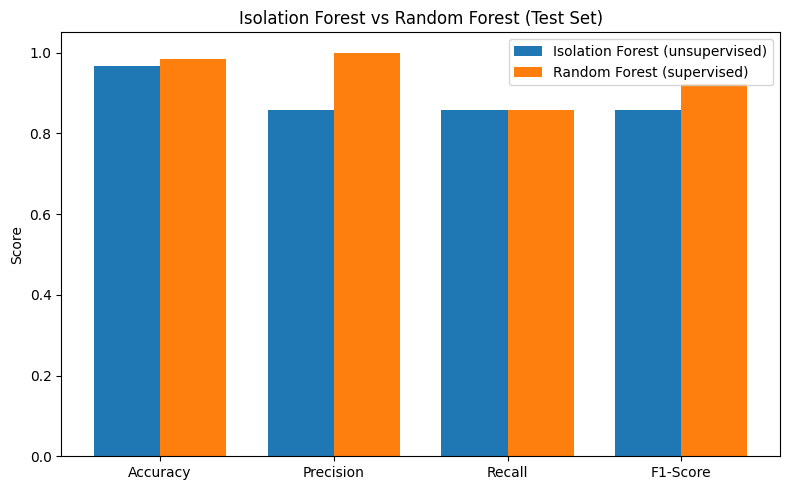

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0)
    }

df_results = pd.DataFrame([
    evaluate_model("Isolation Forest (unsupervised)", y_test, y_pred_if),
    evaluate_model("Random Forest (supervised)",    y_test, y_pred_rf)
])


print(df_results.round(3))

# Bar chart
metrics = ["Accuracy","Precision","Recall","F1-Score"]
x = np.arange(len(metrics)); width = 0.38
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width/2, df_results.loc[0, metrics], width, label=df_results.loc[0, "Model"])
ax.bar(x + width/2, df_results.loc[1, metrics], width, label=df_results.loc[1, "Model"])
ax.set_ylabel("Score")
ax.set_title("Isolation Forest vs Random Forest (Test Set)")
ax.set_xticks(x); ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.05); ax.legend()
plt.tight_layout()

plt.savefig("if_vs_rf.png", dpi=200)
plt.show()
